# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# cd into transcoder_circuits
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

In [ ]:
from sae_training.sparse_autoencoder import SparseAutoencoder
from transformer_lens import HookedTransformer, utils

model = HookedTransformer.from_pretrained('gpt2');model_name="GPT2-124M"

Loaded pretrained model pythia-410m into HookedTransformer


In [5]:
from datasets import load_dataset
from huggingface_hub import HfApi
from utils import tokenize_and_concatenate
from functools import partial

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

In [6]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

In [ ]:
############# gpt2-124m
transcoder_template = "final_mod_gpt2-small_blocks.8.ln2.hook_normalized-saewidth_3072-conditional_True-nexperts_21490-activfn_gelu-glu_False-topk_32-lr_0.0001_totaltokens_480000000"; layer_type="MoD"
base_llm = 'GPT2-124m'

transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_template}.pt").eval()
frequencies =  torch.load(f"{transcoder_template}_log_feature_sparsity.pt")
    
print('use MoD?', transcoder.use_conditional)
print('# experts', transcoder.n_experts)
print('dec norm?', transcoder.cfg.norm_dec)
print('total training tokens', format(transcoder.cfg.total_training_tokens, ','))

print('model config:')
transcoder.cfg

In [69]:
# Clean up memory
import gc
gc.collect()
torch.cuda.empty_cache()

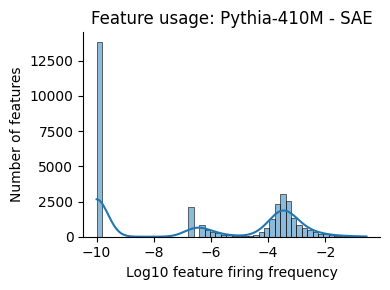

In [ ]:
import seaborn as sns


# plt.hist(utils.to_numpy(frequencies), bins=100)
plt.figure(figsize=(4,3))
sns.histplot(utils.to_numpy(frequencies), bins=50, kde=True)
plt.xlabel("Log10 feature firing frequency")
plt.ylabel("Number of features")
plt.title(f"Feature usage: {model_name} - {layer_type}")
sns.despine()
plt.tight_layout()

plt.savefig(f'feature-sparsity-{model_name}-{layer_type}.pdf')
plt.show()

In [ ]:
feature_idx = 21

start_text = "Let's talk about "
max_new_tokens = 32
num_samples = 10
coeff = 100

def run_generate(start_text, sampling_kwargs, seed=42):
    model.reset_hooks()
    
    if seed is not None: torch.manual_seed(seed)
        
    tokenized = model.to_tokens([start_text] * num_samples)
    result = model.generate(stop_at_eos=False, input=tokenized, max_new_tokens=max_new_tokens, do_sample=True, **sampling_kwargs)

    res_str = model.to_string(result[:, 1:])
    return res_str

print(f'Steering with feature id: {feature_idx}')
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

def a_hook(a, layer, feature_idx):
    a[..., feature_idx] += coeff
    return a

with TranscoderReplacementContext(model, [transcoder]):
    transcoder.a_hook = partial(a_hook, feature_idx=feature_idx)
    generations = run_generate(start_text, sampling_kwargs)
    print(("\n\n" + "-" * 80 + "\n\n").join(generations))
    transcoder.a_hook = None # disable the steering hook for future forward pass

# llm judge

In [ ]:
prompt = f"You are an expert evaluator of synthetic text. TASK: Rate a collection of {num_samples} samples along two independent axes. AXIS 1 – CONCEPT COHERENCE: 0.00  no shared concepts/themes/style. 0.25  faint overlap. 0.50  some overlap or similar structure. 0.75  mostly the same concepts or structure; a few partial drifts. 1.00  all snippets clearly share the same concepts, themes, style, or structure. AXIS 2 – GRAMMATICAL FLUENCY: 0.00  incomprehensible. 0.25  dense errors; meaning often obscured. 0.50  frequent errors; meaning still mostly recoverable. 0.75  minor errors that rarely hinder comprehension. 1.00  completely grammatical and natural. (Do not penalise fluency if a snippet starts or ends abruptly.). SCORING: Choose any real value in [0, 1] for each axis. OUTPUT FORMAT: Respond with exactly two numbers formatted '0.00, 0.00' in the order [coherence, fluency] and no other text or symbols. TEXT TO EVALUATE: "

In [ ]:
import time
from google import genai
from functools import partial


from groq import Groq
groq_client = Groq(
    api_key=groq_api_key,
)

from together import Together
t_client = Together(api_key=t_api_key) # auth defaults to os.environ.get("TOGETHER_API_KEY")

client = genai.Client(api_key=g_api_key)
llm_judge_model1 =  "gemini-2.0-flash"
llm_judge_model2 =  "meta-llama/llama-4-scout-17b-16e-instruct"

num_features = 1
num_features = 100

g_scores = []
c_scores = []
generations = []

for feature_idx in range(num_features):
    with TranscoderReplacementContext(model, [transcoder]):
        transcoder.a_hook = partial(a_hook, feature_idx=feature_idx)
        
        generation = run_generate(start_text, sampling_kwargs)
        generations += [generation]
    
        transcoder.a_hook = None

        content = prompt + ''.join([f'<sample>{x}</sample>' for x in generation])
        
        # query judge model 1
        response = client.models.generate_content(
            model=llm_judge_model1,
            contents=content,
        )

        # query judge model 2
        chat_completion = groq_client.chat.completions.create(
            messages=[{ "role": "user", "content": content }],
            model=llm_judge_model2,
            stream=False,
        )
        g_scores += [response.text] 
        c_scores += [chat_completion.choices[0].message.content]
        
    time.sleep(5)

In [ ]:
import re
c_scores = [re.sub(r'\s+', '', s) for s in c_scores]
g_scores = [re.sub(r'\s+', '', s) for s in g_scores]

# remove anything in addition to returned scores
g_score_strings = [s.replace('\n', '')[:9] for s in g_scores]
c_score_strings = [s.replace('\n', '')[:9] for s in c_scores]

g_score_strings = np.array([[float(x) for x in s.split(',')] for s in g_score_strings])
c_score_strings = np.array([[float(x) for x in s.split(',')] for s in c_score_strings])

scores = [g_score_strings, c_score_strings]

In [83]:
import pickle

print(f'Saving to {layer_type}')
with open(f'./{layer_type}-steering-{base_llm}.pickle', 'wb') as f:
    pickle.dump(scores, f)

Saving to SAE


# load and view saved scores

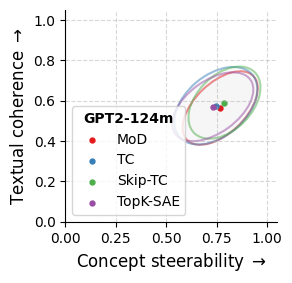

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.patches import Ellipse
colors = colormaps.get_cmap('Set1').colors

def plot_cov_ellipse(mean, eigvals, eigvecs, ax, color, n_std=1.0):
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

    face_rgba = (*color, 0.0)
    edge_rgba = (*color, 1.0)
    
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, lw=1.5)
    ell.set_facecolor((*color, 0.01))
    ell.set_edgecolor((*color, 0.5))
    
    ax.add_patch(ell)

fig, ax = plt.subplots(figsize=(3, 3))

base_llm = 'GPT2-124m'
############# take each judge's score separately as a different point
mod_scores = np.concatenate(np.stack(pickle.load(open(f'./MoD-steering-{base_llm}.pickle', 'rb'))), axis=0)
tc_scores  = np.concatenate(np.stack(pickle.load(open(f'./TC-steering-{base_llm}.pickle', 'rb'))), axis=0)
stc_scores = np.concatenate(np.stack(pickle.load(open(f'./STC-steering-{base_llm}.pickle', 'rb'))), axis=0)
sae_scores = np.concatenate(np.stack(pickle.load(open(f'./SAE-steering-{base_llm}.pickle', 'rb'))), axis=0)

for i, (s, name) in enumerate(zip([mod_scores, tc_scores, stc_scores, sae_scores], ['MoD', 'TC', 'Skip-TC', 'TopK-SAE'])):
    mean = s.mean(axis=0)
    cov = np.cov(s, rowvar=False)
    
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    plot_cov_ellipse(mean, eigvals, eigvecs, ax, color=colors[i], n_std=1.0)
    ax.scatter(*mean, marker='.', s=50, label=name, color=colors[i])
    
ax.set_aspect('equal', 'box')
ax.set_xlim(0,1.05); ax.set_ylim(0,1.05)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Concept steerability $\\rightarrow$', fontsize=12)
ax.set_ylabel('Textual coherence $\\rightarrow$', fontsize=12)
ax.legend(title=base_llm, title_fontproperties={'weight': 'bold', 'size': 10}, loc='lower left')

sns.despine()
plt.tight_layout()
plt.savefig(f'steerability-coherence-{base_llm}.pdf')
plt.show()